# Fellowship.AI Challenge

# 1. Research on the Oxford Flowers102 dataset.

The Oxford Flowers102 dataset is a popular dataset on Kaggle and based off this leaderboard, https://paperswithcode.com/sota/image-classification-on-flowers-102, the best classification accuracy achieved is 99.76% by a CvT-W24 neural network trained with extra data. Without extra data, the best network was a TransBoost-ResNet50 model with 97.85% accuracy. This notebook attempts to recreate the TransBoost-Resnet50 model by using acquiring a pretrained ResNet50 model from Pytorch trained on ImageNet and performing transfer learning on it by training it on the Flowers102 dataset. Based on this article, https://www.hindawi.com/journals/jcse/2021/2518837/tab11/, the best accuracy achieved by transfer learning on a ResNet50 model has an accuracy of 89.28 by transfering learning from image net to Flowers7. Since we aren't going to be doing transfer learning between datasets, we expect the accuracy to be lower.    

### Transfer Learning using ResNet50

Based off these notes, https://cs231n.github.io/transfer-learning/, training a ReNet50 model from scratch on the Flowers102 dataset would be impratical given how little data there is (only around 8000 images) in the dataset. Thus it is common to apply a pretrained model, in our case ResNet50, to the dataset. Since the dataset is small and different from many of ImageNet's categories it would be best to finetune the network by initializing it with the ImageNet weights and performing a similar training loop.

# 2. Training and saving the model

I am most familiar with Pytorch so I will be using a pretrained ResNet50 from Pytorch trained on ImageNet. From here, https://pytorch.org/vision/stable/models.html, it says that ResNet50_Weights.DEFAULT achieved an accuracy of 80.858% on ImageNet and that these are the best weights available.

## Import Pytorch and other dependencies

In [28]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import Flowers102
from torchvision.transforms import transforms
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models


import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import json
import copy
import time
import seaborn as sns

import torch.nn as nn
import torch.optim as optim

from PIL import Image
from sklearn.metrics import confusion_matrix
import pandas as pd

In [13]:
# set to GPU if its available

device = torch.device('cpu')
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPU(s).')
    device = torch.device('cuda:0')
print(f'The device is set to {device}')


Found 1 GPU(s).
The device is set to cuda:0


## Load model and image dataset

In [3]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = model.to(device)

For the data, Udacity provides the dataset with associated labels on https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz. The data is already automatically seperated into a single train/valid/test split which I will use. Since different flower categories have different numbers of images, based on the dataset's description https://www.robots.ox.ac.uk/~vgg/data/flowers/102/, I'm assuming that the split allocates different categories into train/valid/test into the same proportions such that one class doesn't have too many images in one split and not in another.

The data is stored in a folder called "./data2", i.e. to reproduce the results you can untar the file inside this folder.

In [14]:
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize]),

    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),

    'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
    ])
}

training_set = datasets.ImageFolder('data2/train', transform=data_transforms['train'])
validation_set = datasets.ImageFolder('data2/valid', transform=data_transforms['validation'])
test_set = datasets.ImageFolder('data2/test', transform=data_transforms['test'])

print(np.max(training_set.targets))
idx_to_class = { v:k for k,v in training_set.class_to_idx.items()}

# make sure training labels are the same as testing labels to ensure that testing works
assert training_set.class_to_idx == test_set.class_to_idx

# Pytorch's Image folder creates an internal representation of folder names to actual numbered labels 
# So we have to create another map to convert Pytorch label's to folder names and then convert those to actual flower names
print(idx_to_class)

# from https://github.com/bdevnani3/oxfordflowers102-label-name-mapping/blob/main/mapping.json
with open('udacity_label_to_name.json', 'r') as f:
    flower_to_name = json.load(f)


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True, num_workers=0)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)

dataloaders = {'train': training_loader, 'val': validation_loader}
dataset_sizes = {'train': len(training_set), 'val': len(validation_set)}

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))
print('Test set has {} instances'.format(len(test_set)))

101
{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: '90', 93: '91', 94: '92', 95: '93', 96: '94', 97: '95', 98: '96', 99: '97', 100: '98', 

In total, it seems that there are 8189 images in total with 80% for training, 10% for validation, and 10% for testing.

### Sanity Check (Display images)

To make sure that I loaded the data in correctly, I will visualize a few images. Notice that there were preprocessing transforms when moving the data into the dataloader, so we have to undo those transformations here so that we can visualize the images in their original forms. The data preprocessing transforms were performed so that the input images matched the size of the images of ImageNet since we were using a pretrained model. Moreover, there were some random transformations performed in the training dataset as a form of data augmentation as it is a known way to increase model performance without additional data: https://blog.roboflow.com/why-and-how-to-implement-random-rotate-data-augmentation/.

tensor([26, 56, 98, 90, 52, 91, 54, 73])


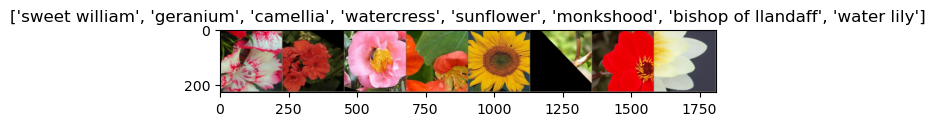

<AxesSubplot: title={'center': "['sweet william', 'geranium', 'camellia', 'watercress', 'sunflower', 'monkshood', 'bishop of llandaff', 'water lily']"}>

In [5]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.permute(1, 2, 0)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image.numpy() + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    plt.show()
    
    return ax


dataiter = iter(training_loader)
images, labels = next(dataiter)
print(labels[0:8])

# Create a grid from the images and show them
out = torchvision.utils.make_grid(images[0:8])
imshow(out, title=[flower_to_name[idx_to_class[labels[j].item()]] for j in range(8)])

We define the training loop when training the model. This loop is almost verbatim to the training loop example provided by Pytorch: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We have to modify the pretrained model to our new set of outputs. Thus, in the final layer we change the output from ImageNets 1000 outputs to 102 outputs.

For the criterion and optimizer, I attempted to use a Negative Log-Likelihood Criterion and an ADAM optimizer (using default parameters) but those gave very poor results (3-30% accuracy). Thus I decided to use the CrossEntropyLoss and Stochastic Gradient Descent optimizer (again with default parameters) since https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html used them and achieved much better results. I also used the same amount of epochs and a learning rate scheduler too to help with convergence.

In [7]:
print(model.fc)
# modifying architecture for transfer learning
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(flower_to_name)).to(device)
model_ft = model.to(device)
epochs = 25
criterion = nn.CrossEntropyLoss()

Linear(in_features=2048, out_features=1000, bias=True)


In [14]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Here is the main transfer learning loop. I trained this on Google Colab using one of its T4 Tensor GPUs and training took approximately 2 hours. Since it took so long I made sure to save it. The training and validation accuracy look pretty good at around 80-90% each.

In [15]:
# train model using transfer learning
model_tl = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=epochs)

Epoch 0/24
----------
train Loss: 4.5497 Acc: 0.0594
val Loss: 4.4001 Acc: 0.1137

Epoch 1/24
----------
train Loss: 4.2317 Acc: 0.1314
val Loss: 3.9054 Acc: 0.1968

Epoch 2/24
----------
train Loss: 3.7035 Acc: 0.2514
val Loss: 3.1171 Acc: 0.3472

Epoch 3/24
----------
train Loss: 2.9603 Acc: 0.4119
val Loss: 2.2285 Acc: 0.5538

Epoch 4/24
----------
train Loss: 2.2423 Acc: 0.5670
val Loss: 1.5077 Acc: 0.7090

Epoch 5/24
----------
train Loss: 1.6525 Acc: 0.6786
val Loss: 1.0034 Acc: 0.8007

Epoch 6/24
----------
train Loss: 1.2052 Acc: 0.7727
val Loss: 0.7015 Acc: 0.8631

Epoch 7/24
----------
train Loss: 1.0457 Acc: 0.8014
val Loss: 0.6814 Acc: 0.8692

Epoch 8/24
----------
train Loss: 1.0085 Acc: 0.8053
val Loss: 0.6502 Acc: 0.8716

Epoch 9/24
----------
train Loss: 0.9853 Acc: 0.8112
val Loss: 0.6367 Acc: 0.8765

Epoch 10/24
----------
train Loss: 0.9562 Acc: 0.8188
val Loss: 0.6269 Acc: 0.8753

Epoch 11/24
----------
train Loss: 0.9378 Acc: 0.8165
val Loss: 0.5830 Acc: 0.8851

Ep

### Saving and Reloading the model

Since the training took so long I would prefer to not have to do it again and save the model so I can simply reload it later.

In [ ]:
model_tl.cpu()
torch.save({'arch': 'resNet50',
            'state_dict': model_tl.state_dict(), 
            'class_to_idx': training_set.class_to_idx}, 
            'resNet50classifierHighestAccuracy.pth')

In [10]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
        
    model.class_to_idx = chpt['class_to_idx']

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(flower_to_name)).to(device)

    model.load_state_dict(chpt['state_dict'])
    model.to(device) 
    return model

In [15]:
model_tl = load_model('resNet50classifierHighestAccuracy.pth')

# 3. Testing Model

We test the model on never before seen images to ensure the model has not overfitted and check its accuracy.

In [16]:
running_accuracy = 0 
total = 0 
model_tl = model_tl.to(device)

with torch.no_grad(): 
	for data in test_loader: 
		inputs, outputs = data
		inputs = inputs.to(device)
		outputs = outputs.to(device)
		outputs = outputs.to(torch.float32) 

		predicted_outputs = model_tl(inputs) 
		_, predicted = torch.max(predicted_outputs, 1) 
		total += outputs.size(0) 
		running_accuracy += (predicted == outputs).sum().item() 

print('Accuracy of the model based on the test set of 819 inputs is: %d %%' % (100 * running_accuracy / total))    

Accuracy of the model based on the test set of 819 inputs is: 59 %


### Perform transforms that were used in training/validation

In [17]:
def process_image(image_path):
    img = Image.open(image_path)
    adjust = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    img_tensor = adjust(img)
    return img_tensor

## Sanity Checking (again)

Determining if the model finds the right label with high probability based on a hand-picked test set (smoke-testing)

In [18]:
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""

    # Undoing the preprocessing transformations
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    model.to(device)
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {flower_to_name[idx_to_class[preds[j].item()]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

To make sure the results aren't misinterpreted/misguided, we look at a few images (6) to see what the model predicted to ensure our results are good and overfitting didn't occur.

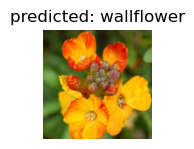

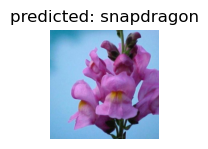

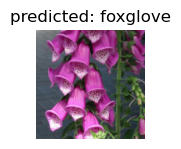

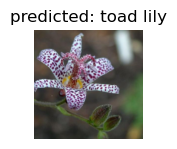

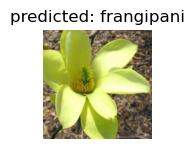

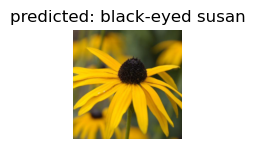

In [19]:
visualize_model(model_tl)

Something else to look into is how the model performs for certain classes compared to others, because perhaps some categories are more challenging than others for the model. So, let's use a confusion matrix. Similar to https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7, we create a confusion matrix and check which classes have the best accuracy.

In [29]:
classes = flower_to_name.values()

In [35]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_tl(images)
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[flower_to_name[idx_to_class[label.cpu().item()]]] += 1
            total_pred[flower_to_name[idx_to_class[label.cpu().item()]]] += 1

        predictions = predictions.data.cpu().numpy()
        labels = labels.data.cpu().numpy()

        y_pred.extend(predictions)
        y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [flower_to_name[v] for k,v in idx_to_class.items()],
                     columns = [flower_to_name[v] for k,v in idx_to_class.items()])
plt.figure(figsize = (150,100))
sns.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: fire lily is 50.0 %
Accuracy for class: canterbury bells is 0.0 %
Accuracy for class: bolero deep blue is 66.7 %
Accuracy for class: pink primrose is 20.0 %
Accuracy for class: mexican aster is 20.0 %
Accuracy for class: prince of wales feathers is 66.7 %
Accuracy for class: moon orchid is 33.3 %
Accuracy for class: globe-flower is 66.7 %
Accuracy for class: grape hyacinth is 60.0 %
Accuracy for class: corn poppy is 20.0 %
Accuracy for class: toad lily is 100.0 %
Accuracy for class: siam tulip is 20.0 %
Accuracy for class: red ginger is 100.0 %
Accuracy for class: spring crocus is 25.0 %
Accuracy for class: alpine sea holly is 83.3 %
Accuracy for class: garden phlox is 0.0 %
Accuracy for class: globe thistle is 100.0 %
Accuracy for class: tiger lily is 55.6 %
Accuracy for class: ball moss is 16.7 %
Accuracy for class: love in the mist is 12.5 %
Accuracy for class: monkshood is 0.0 %
Accuracy for class: blackberry lily is 83.3 %
Accuracy for class: spear thistle is 6

Let's check example beebalm and pincushion flowers since the model seems to be significantly confused between the two.

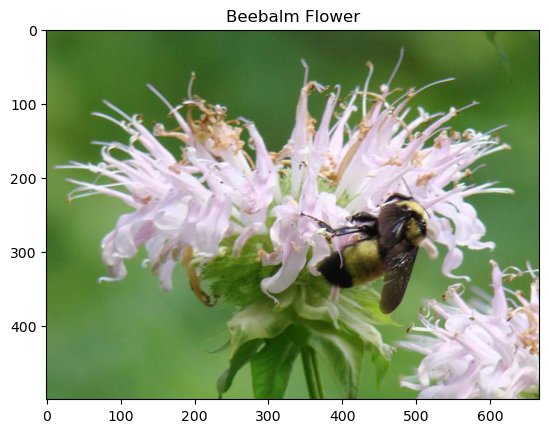

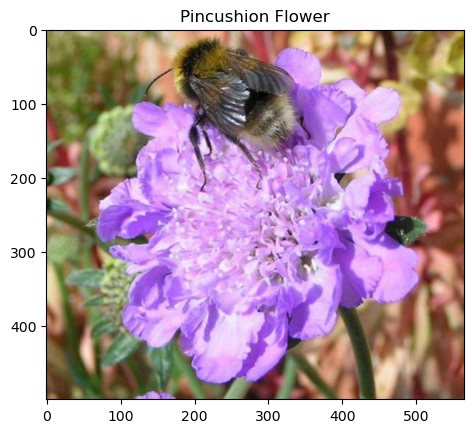

In [41]:
plt.imshow(Image.open("data2/test/92/image_03044.jpg")) # 92 is bee balm
plt.title("Beebalm Flower")
plt.show()
plt.imshow(Image.open("data2/test/22/image_05391.jpg")) # 22 is pincushion
plt.title("Pincushion Flower")
plt.show()

The two flowers don't look too similar, but there are bees in both images which could account for some confusion if the model learned to associate categories by whether or not there was a bee on the flower.

# Conclusion and Possible Improvements

Although I was not able to achieve previously achieved training, testing or validation accuracies (greater than 90%), I was able to achieve training and validations (82.9% and 89.73% respectively) and a 59% testing accuracy using the model. There seemed to be some class confusion occuring between similar looking flowers or having similar objects in them (i.e. bees).

To improve my methods here are some things I would do:

	1. Instead of using a pretrained ResNet50 and its architecture I could have modified its architecture as this repository has done: https://github.com/intsco/udacity-fb-pytorch-project.

	2. Instead of using a predetermined manual split, I could have performed k-folds cross validation and trained *k* models instead, though at significantly higher training times.

	3. Explored TTA - test time augmentation in testing since it has potential to increase test accuracy: https://www.kaggle.com/code/andrewkh/test-time-augmentation-tta-worth-it.

	4. Used different schedulers/optimizers/criterion. ADAM and NLLLoss are typically known to do well in image classification tasks and I am unsure as to why I could not succeed in using them. Moreover, I used the default parameters for each of these, but the parameters could be optimized by plotting learning rate vs loss charts and calculating the optima in which loss is minimized.

	5. Better Image preprocessing/augmentation in training. I only performed random rotations/crops/and flips, but there are numerous different types of transforms Pytorch offers that could potentially also be useful when applied to the training data.

	6. Analyze Precision-Recall/F1-Score during training. As an alternative to accuracy, the precision, recall, and the averaging of the two, the F1 score, per batch can also provide insight into how a model is performing. Depending on what the classification task will be applied to, it might be false negatives could be penalized more than false positives or vice versa. Adding these metrics will help add value to whether or not the model is best at performing the task it is assigned to do.